# Detecting Cybersecurity Threats using Deep Learning

This project demonstrates a binary classification model built using PyTorch. It covers end-to-end steps, including data preprocessing, model definition, training, evaluation, and performance analysis. The dataset used in this project contains labeled data for binary classification tasks.

## Importing libraries

In [3]:
!pip install torchmetrics;

In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data, importing and preparing

In [7]:
# Load preprocessed data
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/labelled_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/labelled_test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/labelled_validation.csv')

# View the first 5 rows of training set
train_df.head()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [22]:
# Prepare data
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values
X_test = test_df.drop('sus_label', axis=1).values
y_test = test_df['sus_label'].values
X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

In [23]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [24]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

## Model, defining, and training

In [25]:
# Define model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

In [26]:
# Initialize loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [27]:
# Training loop
num_epoch = 50
train_losses = []
val_accuracies = []
for epoch in range(num_epoch):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        y_predict_val = model(X_val_tensor).round()
        accuracy = Accuracy(task="binary")
        val_accuracy = accuracy(y_predict_val, y_val_tensor).item()
        val_accuracies.append(val_accuracy)

## Model, evaluation

In [28]:
# Model Evaluation
model.eval()
with torch.no_grad():
    y_predict_train = model(X_train_tensor).round()
    y_predict_test = model(X_test_tensor).round()
    y_predict_val = model(X_val_tensor).round()

In [29]:
train_accuracy = accuracy(y_predict_train, y_train_tensor).item()
test_accuracy = accuracy(y_predict_test, y_test_tensor).item()
val_accuracy = accuracy(y_predict_val, y_val_tensor).item()

print("Training accuracy: {0}".format(train_accuracy))
print("Validation accuracy: {0}".format(val_accuracy))
print("Testing accuracy: {0}".format(test_accuracy))

Training accuracy: 0.9983371496200562
Validation accuracy: 0.9958405494689941
Testing accuracy: 0.09265109896659851


In [30]:
# Metrics
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_predict_test.numpy()))
print("Precision (Test):", precision_score(y_test, y_predict_test.numpy()))
print("Recall (Test):", recall_score(y_test, y_predict_test.numpy()))
print("F1 Score (Test):", f1_score(y_test, y_predict_test.numpy()))

Confusion Matrix (Test):
[[ 17508      0]
 [171459      0]]
Precision (Test): 0.0
Recall (Test): 0.0
F1 Score (Test): 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


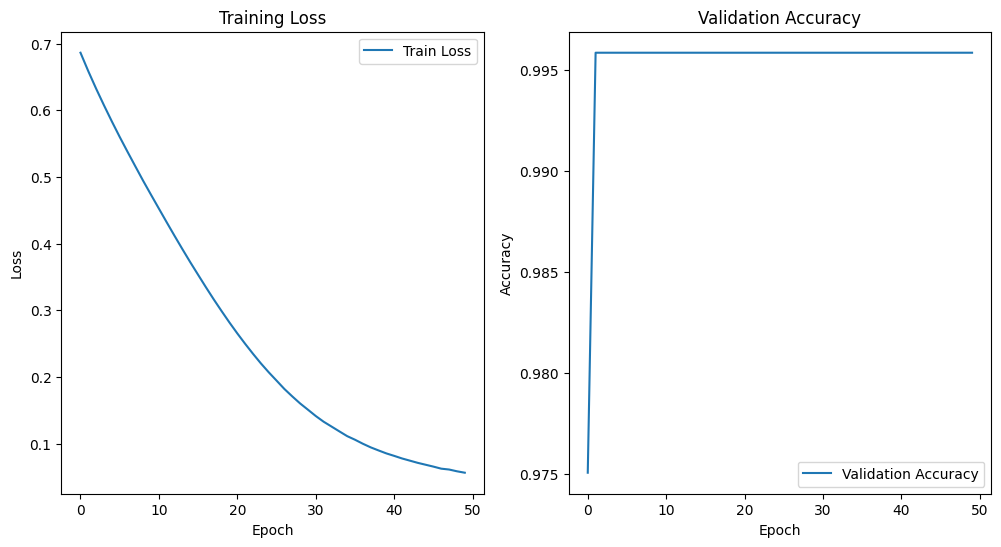

In [31]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()